# Project: Wrangling and Analyze Data


## Table of Contents
<ul>
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#store">Storing Data</a></li>
<li><a href="#analysis">Analyzing and Visualizing Data</a></li>
    
</ul>


In [1]:
#Importing some necessary packages needed in this notebook
import pandas as pd
import requests
import os
from IPython.display import Image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import tweepy
import json
from io import BytesIO
from tweepy import OAuthHandler
from timeit import default_timer as timer

<a id='gather'></a>

## Data Gathering
In this section, I will gather **all** three pieces of data for this project and load them in the notebook. 
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [61]:
#Reading the first data (twitter archieve) into a dataframe
twitter_achieve=pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
#Downloading programmatically
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)

In [5]:
# Make directory if it doesn't already exist. This will be use to store the downloaded file
folder_name = 'image_prediction'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [6]:
#Saving the downloaded file into our folder
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:  #The file will take the name image-predictions.tsv in the new folder
    file.write(response.content)

In [7]:
#Reading the file into a pandas dataframe.
image_prediction=pd.read_csv('image_prediction/image-predictions.tsv', sep='\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
api_key = 'M6QyoHbqBu6aDN5giuCRFunWV'
api_secret = 'Edrc7kLHvtCfAwU8JrWg7hvgOJqtD9dIgZuGwRghuu5hYM6ZNG'
access_token = '2949531137-Dq30NeoHufiCZZww8hyK0dnNrfNP8vGvCols80k'
access_secret = 'VDmFNvODVEe8R9YmBASmEs3HjJRCjY1kVmrgH04b0pAcg'

auth = OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True)

In [9]:
#Download Tweepy status object based on Tweet ID and store in list
succeeded_tweets = []

# Tweets that failed to be found are saved in the list below:
#cant_find_tweets_for_those_ids = []
failed_tweets = []

# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_achieve.tweet_id.values

#NOTE: this loop may take long time (30 to 35 minutes)
for tweet_id in tweet_ids:   
    try:
        succeeded_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        failed_tweets.append(tweet_id)

Rate limit reached. Sleeping for: 127
Rate limit reached. Sleeping for: 108


In [10]:
#Printing the number of each list count
print("The succeeded tweets counts:" ,len(succeeded_tweets))
print("The failed tweets counts:" , len(failed_tweets))

The succeeded tweets counts: 2327
The failed tweets counts: 29


In [11]:
#Adding json part of each succeeded tweet into a list
succeeded_tweets_json = []
for each_succeeded_tweet in succeeded_tweets:
    succeeded_tweets_json.append(each_succeeded_tweet)

In [12]:
#store each tweet's entire set of JSON data in a file called tweet_json.txt
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(succeeded_tweets_json, indent=4))

In [13]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
json_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        json_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(json_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [14]:
#The 3rd dataframe read from txt file generated
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2327 non-null   object
 1   favorite_count    2327 non-null   int64 
 2   retweet_count     2327 non-null   int64 
 3   followers_count   2327 non-null   int64 
 4   friends_count     2327 non-null   int64 
 5   source            2327 non-null   object
 6   retweeted_status  2327 non-null   object
 7   url               2327 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


<a id='assess'></a>
## Assessing the Data
After gathering all three pieces of data, I will assess them **visually** and **programmatically** for quality and tidiness issues.

>### Visual Assessment
Each piece of gathered data is displayed in this Jupyter Notebook for visual assessment purposes

1. Starting with **The WeRateDogs Twitter archive** dataset. Named _twitter_achieve_ dataframe in this notebook

In [15]:
#Displaying the data visually 
twitter_achieve

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


2. **The tweet image predictions** dataset. Named _image_prediction_ dataframe in this notebook

In [16]:
#Displaying the data visually 
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


3. **Additional data from the Twitter API** dataset. Named _tweet_json_ dataframe in this notebook

In [17]:
#Displaying the data visually 
tweet_json

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,33810,7005,9298700,21,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,29325,5301,9298700,21,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22046,3478,9298700,21,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,36930,7225,9298700,21,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,35309,7757,9298700,21,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
...,...,...,...,...,...,...,...,...
2322,666049248165822465,89,37,9298715,21,Twitter for iPhone,Original tweet,https://t.co/4B7cOc1EDq
2323,666044226329800704,247,115,9298715,21,Twitter for iPhone,Original tweet,https://t.co/DWnyCjf2mx
2324,666033412701032449,100,36,9298715,21,Twitter for iPhone,Original tweet,https://t.co/y671yMhoiR
2325,666029285002620928,112,39,9298715,21,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI


>### Programmatic Assessment
In this section, I am using pandas' functions and/or methods to assess the data.

1. Starting with **The WeRateDogs Twitter archive** dataset. Named _twitter_achieve_ dataframe in this notebook

In [18]:
#10 Sample entries from the dataset
twitter_achieve.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1294,707995814724026368,NaN,NaN,2016-03-10 18:25:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Farfle. He lost his back legs during t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707995814...,12,10,Farfle,None,None,None,None
2090,670786190031921152,NaN,NaN,2015-11-29 02:07:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Creg. You offered him a ride to work b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670786190...,8,10,Creg,None,None,None,None
1832,676191832485810177,NaN,NaN,2015-12-14 00:07:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pups just met and have instantly bon...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676191832...,10,10,None,None,None,None,None
1031,745422732645535745,NaN,NaN,2016-06-22 01:06:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/745422732...,9,10,very,None,None,None,None
2001,672482722825261057,NaN,NaN,2015-12-03 18:29:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is light saber pup. Ready to fight off ev...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672482722...,10,10,light,None,None,None,None
753,778774459159379968,NaN,NaN,2016-09-22 01:54:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: In case you haven't seen the mo...,7.580996e+17,4.196984e+09,2016-07-27 00:40:12 +0000,"https://vine.co/v/hQJbaj1VpIz,https://vine.co/...",13,10,None,None,None,None,None
1809,676864501615042560,NaN,NaN,2015-12-15 20:40:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ash. He's just a head now. Lost his body ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676864501...,10,10,Ash,None,None,None,None
1553,688908934925697024,NaN,NaN,2016-01-18 02:21:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Clarence. He does parkour. 8/10 very tale...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688908934...,8,10,Clarence,None,None,None,None
768,777621514455814149,NaN,NaN,2016-09-18 21:33:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. You can't look at him and not s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/777621514...,12,10,Derek,None,None,None,None
2329,666373753744588802,NaN,NaN,2015-11-16 21:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Those are sunglasses and a jean jacket. 11/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666373753...,11,10,None,None,None,None,None


In [19]:
#Get a quick overview of the dataset
twitter_achieve.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [20]:
# View descriptive statistics of the dataset
twitter_achieve.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
#Check for duplicated entries
twitter_achieve[twitter_achieve.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [22]:
# number of missing values for each feature
twitter_achieve.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [23]:
#Checking for consistency of name column
# Example of inconsistency is a name starting with lower case
twitter_achieve['name'].str.islower().sum()

109

2. **The tweet image predictions** dataset. Named _image_prediction_ dataframe in this notebook

In [24]:
#10 Sample entries from the dataset
image_prediction.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1027,710844581445812225,https://pbs.twimg.com/media/Cd1tYGmXIAAoW5b.jpg,1,dingo,0.536593,False,Pembroke,0.200407,True,basenji,0.060734,True
307,671533943490011136,https://pbs.twimg.com/media/CVHEju0XAAEUZRY.jpg,1,hen,0.556524,False,cock,0.442033,False,black_swan,0.001181,False
1739,822462944365645825,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,3,Pomeranian,0.960199,True,Samoyed,0.023056,True,Maltese_dog,0.008945,True
804,691675652215414786,https://pbs.twimg.com/media/CZlTVL4WkAEpVR5.jpg,1,Chihuahua,0.182898,True,teddy,0.128077,False,West_Highland_white_terrier,0.097875,True
1998,875144289856114688,https://pbs.twimg.com/ext_tw_video_thumb/87514...,1,Siberian_husky,0.245048,True,Pembroke,0.223716,True,dingo,0.160753,False
473,675146535592706048,https://pbs.twimg.com/media/CV6aMToXIAA7kH4.jpg,1,dingo,0.288447,False,Cardigan,0.229944,True,Pembroke,0.190407,True
645,681610798867845120,https://pbs.twimg.com/media/CXWRZBgWkAEHMea.jpg,1,toy_poodle,0.821704,True,miniature_poodle,0.116042,True,Yorkshire_terrier,0.014847,True
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
73,667369227918143488,https://pbs.twimg.com/media/CUL4xR9UkAEdlJ6.jpg,1,teddy,0.709545,False,bath_towel,0.127285,False,Christmas_stocking,0.028567,False
1658,810984652412424192,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True


In [25]:
#Get a quick overview of the dataset
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [26]:
# View descriptive statistics of the dataset
image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [27]:
#Check for duplicated entries
image_prediction[image_prediction.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [28]:
#Check duplicates in jpg_url as same url means duplicated data
image_prediction[image_prediction.jpg_url.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1315,754874841593970688,https://pbs.twimg.com/media/CWza7kpWcAAdYLc.jpg,1,pug,0.272205,True,bull_mastiff,0.251530,True,bath_towel,0.116806,False
1333,757729163776290825,https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg,2,cash_machine,0.802333,False,schipperke,0.045519,True,German_shepherd,0.023353,True
1345,759159934323924993,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
1349,759566828574212096,https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg,1,Labrador_retriever,0.967397,True,golden_retriever,0.016641,True,ice_bear,0.014858,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True


In [29]:
# number of missing values for each feature
image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [30]:
#Checking for consistency of dog name 1st prediction column
# Example of inconsistency is a name starting with lower case
image_prediction['p1'].str.islower().sum()

1135

In [31]:
#Checking for consistency of dog name 2nd prediction column
# Example of inconsistency is a name starting with lower case
image_prediction['p2'].str.islower().sum()

1096

In [32]:
#Checking for consistency of dog name 3rd prediction column
# Example of inconsistency is a name starting with lower case
image_prediction['p3'].str.islower().sum()

1131

In [33]:
#Statistic of whether or not the #1 prediction is a breed of dog
image_prediction.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [34]:
#Statistic of whether or not the #2 prediction is a breed of dog
image_prediction.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [35]:
#Statistic of whether or not the #3 prediction is a breed of dog
image_prediction.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

3. **Additional data from the Twitter API** dataset. Named _tweet_json_ dataframe in this notebook

In [36]:
#10 Sample entries from the dataset
tweet_json.sample(10)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
1976,672272411274932228,5726,2933,9298713,21,Twitter for iPhone,Original tweet,https://t.co/ZICNl6tIr5
2325,666029285002620928,112,39,9298715,21,Twitter for iPhone,Original tweet,https://t.co/r7mOb2m0UI
543,802600418706604034,6767,1383,9298702,21,Vine - Make a Scene,Original tweet,https://t.co/urhl90ZE1O
1182,715680795826982913,3980,1447,9298698,21,Twitter for iPhone,Original tweet,https://t.co/sSugyyRuTp
1499,690360449368465409,2456,796,9298704,21,Twitter for iPhone,Original tweet,https://t.co/B9ZXXKJYNx
772,773336787167145985,0,4671,9298691,21,Twitter for iPhone,This is a retweet,This is a retweet
1175,716285507865542656,2561,969,9298698,21,Twitter for iPhone,Original tweet,https://t.co/WIWabMngQZ
1464,692828166163931137,2662,799,9298703,21,Twitter for iPhone,Original tweet,https://t.co/X6X9wM7NuS
1656,681679526984871937,1628,400,9298705,21,Twitter for iPhone,Original tweet,https://t.co/3uCcDEJLXs
81,876838120628539392,18211,2803,9298700,21,Twitter for iPhone,Original tweet,https://t.co/zuDk9mBEMO


In [37]:
#Get a quick overview of the dataset
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2327 non-null   object
 1   favorite_count    2327 non-null   int64 
 2   retweet_count     2327 non-null   int64 
 3   followers_count   2327 non-null   int64 
 4   friends_count     2327 non-null   int64 
 5   source            2327 non-null   object
 6   retweeted_status  2327 non-null   object
 7   url               2327 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


In [38]:
# View descriptive statistics of the dataset
tweet_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2327.000000,2327.000000,2.327000e+03,2327.0
mean,7053.085948,2470.310700,9.298710e+06,21.0
std,10960.657569,4183.608386,5.845628e+01,0.0
min,0.000000,1.000000,9.298689e+06,21.0
25%,1224.500000,494.000000,9.298698e+06,21.0
50%,3051.000000,1148.000000,9.298702e+06,21.0
75%,8603.500000,2860.500000,9.298709e+06,21.0
max,144850.000000,70709.000000,9.299191e+06,21.0


In [39]:
#Check for duplicated entries
tweet_json[tweet_json.tweet_id.duplicated()]

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url


In [40]:
# number of missing values for each feature
tweet_json.isnull().sum()

tweet_id            0
favorite_count      0
retweet_count       0
followers_count     0
friends_count       0
source              0
retweeted_status    0
url                 0
dtype: int64

In [41]:
#Check the stats of values in retweeted_status
tweet_json.retweeted_status.value_counts()

Original tweet       2167
This is a retweet     160
Name: retweeted_status, dtype: int64

In [42]:
#Check the stats of values in source
tweet_json.source.value_counts()

Twitter for iPhone     2193
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                10
Name: source, dtype: int64

In [43]:
# Top 10 retweet_count entries
tweet_json.sort_values(['retweet_count'], ascending= 0)[0:10]

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
1011,744234799360020481,144850,70709,9298697,21,Twitter for iPhone,Original tweet,https://t.co/7wE9LTEXC4
1051,739238157791694849,107242,52886,9298697,21,Twitter for iPhone,Original tweet,https://t.co/YcXgHfp1EC
515,807106840509214720,111681,51663,9298702,21,Twitter for iPhone,Original tweet,https://t.co/DkBYaCAg2d
395,822872901745569793,124098,39913,9298700,21,Twitter for iPhone,Original tweet,https://t.co/nTz3FtorBc
65,879415818425184262,92850,37448,9298700,21,Twitter for iPhone,Original tweet,https://t.co/UDT7ZkcTgY
431,819004803107983360,82709,34540,9298701,21,Twitter for iPhone,Original tweet,https://t.co/AdPKrI8BZ1
428,819015337530290176,0,34540,9298701,21,Twitter for iPhone,This is a retweet,This is a retweet
518,806629075125202948,70597,32384,9299102,21,Twitter for iPhone,Original tweet,https://t.co/f1h2Fsalv9
129,866450705531457537,108890,30205,9298701,21,Twitter for iPhone,Original tweet,https://t.co/wk7TfysWHr
1737,678399652199309312,73529,28588,9298706,21,Twitter for iPhone,Original tweet,https://t.co/VRTbo3aAcm


In [44]:
# Top 10 favorite_count entries
tweet_json.sort_values(['favorite_count'], ascending= 0)[0:10]

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
1011,744234799360020481,144850,70709,9298697,21,Twitter for iPhone,Original tweet,https://t.co/7wE9LTEXC4
395,822872901745569793,124098,39913,9298700,21,Twitter for iPhone,Original tweet,https://t.co/nTz3FtorBc
515,807106840509214720,111681,51663,9298702,21,Twitter for iPhone,Original tweet,https://t.co/DkBYaCAg2d
129,866450705531457537,108890,30205,9298701,21,Twitter for iPhone,Original tweet,https://t.co/wk7TfysWHr
1051,739238157791694849,107242,52886,9298697,21,Twitter for iPhone,Original tweet,https://t.co/YcXgHfp1EC
65,879415818425184262,92850,37448,9298700,21,Twitter for iPhone,Original tweet,https://t.co/UDT7ZkcTgY
431,819004803107983360,82709,34540,9298701,21,Twitter for iPhone,Original tweet,https://t.co/AdPKrI8BZ1
162,859196978902773760,80581,26279,9298701,21,Twitter for iPhone,Original tweet,https://t.co/r6huxnDPOZ
111,870374049280663552,73957,22750,9298701,21,Twitter for iPhone,Original tweet,https://t.co/6SWu4xkvDk
1737,678399652199309312,73529,28588,9298706,21,Twitter for iPhone,Original tweet,https://t.co/VRTbo3aAcm


### Cleaning Decision Summary

#### Quality issues
1. `twitter_achieve` table: Present of **retweeted entries**. As per project specification, they are not needed. 

2. `twitter_achieve` table: **expanded_urls, source, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id** and **retweeted_status_timestamp** columns are not needed for this analysis

3. `twitter_achieve` table: Erroneous datatypes (timestamp)

4. `twitter_achieve` table: Inconsistency of dog names (name)

5. `twitter_achieve` table: Dogs rating not standard

6. `image_prediction` table: Non-decriptive column names (p1,p1_conf, p1_dog, etc.)

7. `image_prediction` table: Inconsistency of predicted dog names

8. `image_prediction` table: Duplicated jpg_url

9. `tweet_json` table: **followers_count, friends_count, source, retweeted_status** and **url** columns are not neccessary for this analysis

10. **tweet_id** column has different data types across the data sources (tables). This issue need to be addressed to address one of the mentioned tidiness issues below.

#### Tidiness issues

1. `twitter_achieve` table: The **doggo, floofer, pupper** and **puppo** columns violate the first rule of tidiness: that each variable forms a column.

2. Different data sources/ pieces (twitter_achieve, image_prediction and tweet_json)

<a id='clean'></a>
## Cleaning Data
In this section, I will clean **all** of the issues documented while assessing. 

In [62]:
# Make copies of original pieces of data
twitter_achieve_clean=twitter_achieve.copy()
image_prediction_clean=image_prediction.copy()
tweet_json_clean=tweet_json.copy()

>## Quality Issues

### Issue #1:

`twitter_achieve` table: Present of **retweeted entries**. As per project specification, they are not needed.

#### Define: remove all rows that have values (not blank or non-null) in retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp columns which are related to retweet entries.

#### Code

In [63]:
#Removing the rows with retweeted entries values
twitter_achieve = twitter_achieve[twitter_achieve.retweeted_status_id.isnull()]
twitter_achieve = twitter_achieve[twitter_achieve.retweeted_status_user_id.isnull()]
twitter_achieve = twitter_achieve[twitter_achieve.retweeted_status_timestamp.isnull()]

#### Test

In [64]:
#Check if the code work as intended
twitter_achieve.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

Hurray! All the rows that have values in retweeted-related columns are now removed.

### Issue #2:

 `twitter_achieve` table: **expanded_urls, source, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id** and **retweeted_status_timestamp** columns are not needed for this analysis

#### Define: Drop the columns that are not needed for the analysis

#### Code

In [65]:
twitter_achieve_clean = twitter_achieve_clean.drop(['expanded_urls','source','in_reply_to_status_id','in_reply_to_user_id',
                                'retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp'], 1)

C:\Users\umarf\AppData\Local\Temp/ipykernel_9744/2298627700.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  twitter_achieve_clean = twitter_achieve_clean.drop(['expanded_urls','source','in_reply_to_status_id','in_reply_to_user_id',


#### Test

In [66]:
#Check to see if the code works as intended
twitter_achieve_clean.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None


That's awesome, the issue is now cleaned. Which include droping columns that are empty as a result of first issue been addressed.

### Issue #3:

`twitter_achieve` table: Erroneous datatypes (timestamp)

#### Define: Change the datatype of `timestamp` to datetime

#### Code

In [67]:
#Change the datatype of timestamp column from object to datetime
twitter_achieve_clean['timestamp'] = pd.to_datetime(twitter_achieve_clean['timestamp'])

#### Test

In [68]:
#Check to see if the code works
twitter_achieve_clean.timestamp.dtype

datetime64[ns, UTC]

Yeah! It works fine. This issue is also cleaned as well.

### Issue #4:

`twitter_achieve` table: Inconsistency of dog names (name)

#### Define: The dog names in the `name` column should be capitalized. i.e the names should start with capiital letters

#### Code

In [69]:
#Capitalize the first letters of dog names in the name column
twitter_achieve_clean['name'] = twitter_achieve_clean.name.str.capitalize()

#### Test

In [70]:
#Check if the names are capitalize. 0 means no name that start with small letter
twitter_achieve_clean['name'].str.islower().sum()

0

Issue is well cleaned as well. 

### Issue #5:

`twitter_achieve` table: Dogs rating not standard

#### Define: Create new column `rating` to calculate the standardized rates of the dogs

#### Code

In [71]:
# Create a new column called rating, and calulate the value with new, standardized ratings
twitter_achieve_clean['rating'] = twitter_achieve_clean['rating_numerator'] / twitter_achieve_clean['rating_denominator']

#### Test

In [72]:
#Check the new created column with standard rating
twitter_achieve_clean.sample(5)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
1487,693095443459342336,2016-01-29 15:36:45+00:00,This is Milo. He doesn't understand your fancy...,10,10,Milo,None,None,pupper,None,1.0
1564,688116655151435777,2016-01-15 21:52:49+00:00,Please send dogs. I'm tired of seeing other st...,10,10,None,None,None,None,None,1.0
1085,738184450748633089,2016-06-02 01:44:22+00:00,"For the last time, we only rate dogs. Pls stop...",9,10,None,None,None,None,None,0.9
1838,675898130735476737,2015-12-13 04:40:46+00:00,I'm sure you've all seen this pupper. Not prep...,10,10,None,None,None,pupper,None,1.0
1250,711008018775851008,2016-03-19 01:54:56+00:00,This is Chuckles. He had a balloon but he acci...,11,10,Chuckles,None,None,pupper,None,1.1


Awesomely done! The new column `rating` contain the values of rating in simple form. This issue is also cleaned as well.

### Issue #6:

`image_prediction` table: Non-decriptive column names (p1,p1_conf, p1_dog, etc.)

#### Define: the aforementioned columns should be rename to more descriptive names

#### Code

In [73]:
image_prediction_clean.head(0)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [74]:
#Renaming the colunms to more descriptive names
image_prediction_clean.rename(columns={'p1':'first_prediction', 'p1_conf': 'first_confidence', 'p1_dog': 'first_dog',
                                  'p2': 'second_prediction', 'p2_conf': 'second_confidence', 'p2_dog': 'second_dog',
                                  'p3': 'third_prediction', 'p3_conf': 'third_confidence', 'p3_dog': 'third_dog'}, inplace = True)

#### Test

In [75]:
#Check to see if the column names have been rename successfully
image_prediction_clean.head(1)

,tweet_id,jpg_url,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


It really feels good! The data is continuely been cleaned. This issue is no more.

### Issue #7:

`image_prediction` table: Inconsistency of predicted dog names

#### Define: Rename the predicted names of the dogs contained in `first_prediction`, `second_prediction`, `third_prediction` to be consistent. All the names should start with capital letters.

#### Code

In [76]:
#Rename the columns' values for consistency
image_prediction_clean['first_prediction'] = image_prediction_clean.first_prediction.str.capitalize()
image_prediction_clean['second_prediction'] = image_prediction_clean.second_prediction.str.capitalize()
image_prediction_clean['third_prediction'] = image_prediction_clean.third_prediction.str.capitalize()

#### Test

In [77]:
#number of names that start with small letters in first_prediction
image_prediction_clean['first_prediction'].str.islower().sum()

0

In [78]:
#number of names that start with small letters in second_prediction
image_prediction_clean['second_prediction'].str.islower().sum()

0

In [79]:
#number of names that start with small letters in third_prediction
image_prediction_clean['third_prediction'].str.islower().sum()

0

Unlike before, now no single name that start with small letter across all the three predictions. The issue is cleaned.

### Issue #8:

`image_prediction` table: Duplicated jpg_url

#### Define: Since we are dealing with images here, no image of dog should have same url with another. Meanwhile, the duplicated `jpg_url` should be droped

#### Code

In [80]:
#Here there are 66 duplicated jpg_url before cleaning
sum(image_prediction_clean['jpg_url'].duplicated())

66

In [81]:
#Droping the duplicated data
image_prediction_clean = image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='first')

#### Test

In [82]:
#Check to see if there are duplicated jpg_url after cleaning. 0 means no duplicated.
sum(image_prediction_clean['jpg_url'].duplicated())

0

Steady cleaning! The data is becoming more and more cleaned. This issue is no longer existing

### Issue #9:

`tweet_json` table: **followers_count, friends_count, source, retweeted_status** and **url** columns are not neccessary for this analysis

In [83]:
tweet_json_clean.head(0)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url


#### Define: Drop all the columns leaving the minimum required columns (`tweet_id`, `favorite_count` and `retweet_count`)

#### Code

In [84]:
#Drop followers_count, friends_count, source, retweeted_status and url as they are not neccessary
tweet_json_clean=tweet_json_clean.drop(['followers_count','friends_count','source','retweeted_status', 'url'],1)

C:\Users\umarf\AppData\Local\Temp/ipykernel_9744/2641524648.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tweet_json_clean=tweet_json_clean.drop(['followers_count','friends_count','source','retweeted_status', 'url'],1)


#### Test

In [85]:
#Check to see if the columns are droped and minimum required remained
tweet_json_clean.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,33810,7005
1,892177421306343426,29325,5301
2,891815181378084864,22046,3478
3,891689557279858688,36930,7225
4,891327558926688256,35309,7757


### Issue #10:

**tweet_id** column has different data types across the data sources (tables). This might cause issue when or after merging the tables into one table.

#### Define: Change `tweet_id` column (from twitter_achieve and image_prediction tables) to type string (object) in order to merge with the other table (tweet_json)

#### Code

In [86]:
#Change the datatype of tweet_id column in twitter_achieve table to string
twitter_achieve_clean['tweet_id'] = twitter_achieve_clean['tweet_id'].astype(str)

In [87]:
#Change the datatype of tweet_id column in image_prediction table to string
image_prediction_clean['tweet_id'] = image_prediction_clean['tweet_id'].astype(str)

#### Test

In [88]:
#Check the datatype of tweet_id column in twitter_achieve
twitter_achieve_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   object             
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   text                2356 non-null   object             
 3   rating_numerator    2356 non-null   int64              
 4   rating_denominator  2356 non-null   int64              
 5   name                2356 non-null   object             
 6   doggo               2356 non-null   object             
 7   floofer             2356 non-null   object             
 8   pupper              2356 non-null   object             
 9   puppo               2356 non-null   object             
 10  rating              2356 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(7)
memory usage: 202.6+ KB


In [89]:
#Check the datatype of tweet_id column in image_prediction
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2009 non-null   object 
 1   jpg_url            2009 non-null   object 
 2   img_num            2009 non-null   int64  
 3   first_prediction   2009 non-null   object 
 4   first_confidence   2009 non-null   float64
 5   first_dog          2009 non-null   bool   
 6   second_prediction  2009 non-null   object 
 7   second_confidence  2009 non-null   float64
 8   second_dog         2009 non-null   bool   
 9   third_prediction   2009 non-null   object 
 10  third_confidence   2009 non-null   float64
 11  third_dog          2009 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 162.8+ KB


Now all the `tweet_id` columns across the three pieces of data are of same datatype. This issue is also cleaned.

#### Done with cleaning all the aforementioned quality issues.

>## Tideness Issues

### Issue #1:

`twitter_achieve` table: The **doggo, floofer, pupper** and **puppo** columns violate the first rule of tidiness: that each variable forms a column.

#### Define: Create one column `dog_stage` for the various dog stages: doggo, floofer, pupper and puppo. Then drop the `doggo`, `floofer`, `pupper`, and `puppo` columns

#### Code

In [90]:
# Extract the dog stage from the text column into the new dog_stage colunn
twitter_achieve_clean['dog_stage'] = twitter_achieve_clean['text'].str.extract('(doggo|floofer|pupper|puppo)')

#### Test

In [91]:
#Check to see if the new column is created and appropriate values are their as expected
twitter_achieve_clean.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating,dog_stage
662,790987426131050500,2016-10-25 18:44:32+00:00,This is Misty. She has a cowboy hat on her nos...,12,10,Misty,None,None,None,None,1.2,NaN
2082,670815497391357952,2015-11-29 04:04:12+00:00,This is Sage. He likes to burn shit. 10/10 htt...,10,10,Sage,None,None,None,None,1.0,NaN
799,772826264096874500,2016-09-05 15:58:34+00:00,Meet Roosevelt. He's preparing for takeoff. Ma...,11,10,Roosevelt,None,None,None,None,1.1,NaN
1245,711732680602345472,2016-03-21 01:54:29+00:00,I want to hear the joke this dog was just told...,10,10,None,None,None,None,None,1.0,NaN
2029,671855973984772097,2015-12-02 00:58:41+00:00,Remarkable dog here. Walks on back legs really...,8,10,None,None,None,None,None,0.8,NaN
545,805826884734976000,2016-12-05 17:31:15+00:00,This is Duke. He is not a fan of the pupporazz...,12,10,Duke,None,None,None,None,1.2,puppo
2098,670727704916926465,2015-11-28 22:15:21+00:00,This is Jeffrie. He's a handheld pup. Excellen...,10,10,Jeffrie,None,None,None,None,1.0,NaN
1366,702671118226825216,2016-02-25 01:47:04+00:00,Meet Rambo &amp; Kiwi. Rambo's the pup with th...,10,10,Rambo,None,None,None,None,1.0,NaN
250,845098359547420673,2017-03-24 02:22:04+00:00,RT @dog_rates: This is Bungalo. She uses that ...,12,10,Bungalo,None,None,None,None,1.2,NaN
1114,732732193018155009,2016-05-18 00:39:02+00:00,This is Ralpher. He's an East Guinean Flop Dog...,12,10,Ralpher,None,None,None,None,1.2,NaN


#### Code

In [92]:
#Drop the four columns that are all replaced with the new column
twitter_achieve_clean=twitter_achieve_clean.drop(['doggo','floofer','pupper','puppo'],1)

C:\Users\umarf\AppData\Local\Temp/ipykernel_9744/2687410763.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  twitter_achieve_clean=twitter_achieve_clean.drop(['doggo','floofer','pupper','puppo'],1)


#### Test

In [93]:
#Check to see if the new column is created and the no longer needed columns are dropped
twitter_achieve_clean.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rating,dog_stage
724,782747134529531904,2016-10-03 01:00:34+00:00,This is Deacon. He's the happiest almost dry d...,11,10,Deacon,1.1,doggo
1134,728653952833728512,2016-05-06 18:33:34+00:00,This is Coleman. Somebody needs to tell him th...,8,10,Coleman,0.8,NaN
1008,747594051852075008,2016-06-28 00:54:46+00:00,Again w the sharks guys. This week is about do...,11,10,None,1.1,NaN
2316,666649482315059201,2015-11-17 16:09:56+00:00,Cool dog. Enjoys couch. Low monotone bark. Ver...,4,10,None,0.4,NaN
1718,680176173301628928,2015-12-25 00:00:11+00:00,This pupper is patiently waiting to scare the ...,10,10,None,1.0,pupper
887,759923798737051648,2016-08-01 01:28:46+00:00,We only rate dogs... this is a Taiwanese Guide...,10,10,None,1.0,NaN
605,798576900688019456,2016-11-15 17:22:24+00:00,RT @dog_rates: Not familiar with this breed. N...,1,10,None,0.1,NaN
1598,686035780142297088,2016-01-10 04:04:10+00:00,Yes I do realize a rating of 4/20 would've bee...,4,20,None,0.2,NaN
218,850333567704068097,2017-04-07 13:04:55+00:00,@markhoppus MARK THAT DOG HAS SEEN AND EXPERIE...,13,10,None,1.3,NaN
2050,671497587707535361,2015-12-01 01:14:35+00:00,This is Pip. He is a ship captain. Many years ...,11,10,Pip,1.1,NaN


**The mentioned first tideness issue is cleaned** 

### Issue #2:

Different data sources/ pieces (twitter_achieve, image_prediction and tweet_json)

#### Define: Merge all the data pieces into one table (dataframe)

#### Code

In [94]:
#image_prediction_clean to twitter_achieve_clean
master_v1 = pd.merge(twitter_achieve_clean, 
                      image_prediction_clean, 
                      how = 'left', on = ['tweet_id'])

#keep rows that have picture (jpg_url)
master_v1 = master_v1[master_v1['jpg_url'].notnull()]

#### Test

In [95]:
master_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2009 non-null   object             
 1   timestamp           2009 non-null   datetime64[ns, UTC]
 2   text                2009 non-null   object             
 3   rating_numerator    2009 non-null   int64              
 4   rating_denominator  2009 non-null   int64              
 5   name                2009 non-null   object             
 6   rating              2009 non-null   float64            
 7   dog_stage           329 non-null    object             
 8   jpg_url             2009 non-null   object             
 9   img_num             2009 non-null   float64            
 10  first_prediction    2009 non-null   object             
 11  first_confidence    2009 non-null   float64            
 12  first_dog           2009 non-null 

#### Code

In [96]:
#Now merging them all together
we_rate_dogs_master = pd.merge(master_v1, tweet_json_clean, 
                      how = 'left', on = ['tweet_id'])

I merged the pieces of data into one dataframe because of <a href="https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html"> rules of tidy data</a>

#### Test

In [97]:
#visually displaying the high-quality and tidy tadaframe (master)
we_rate_dogs_master

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rating,dog_stage,jpg_url,img_num,...,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,1.3,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,...,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False,33810.0,7005.0
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,1.3,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,...,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True,29325.0,5301.0
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,1.2,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,...,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True,22046.0,3478.0
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,13,10,Darla,1.3,NaN,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,...,0.170278,False,Labrador_retriever,0.168086,True,Spatula,0.040836,False,36930.0,7225.0
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,1.2,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,35309.0,7757.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004,666049248165822465,2015-11-16 00:24:50+00:00,Here we have a 1949 1st generation vulpix. Enj...,5,10,None,0.5,NaN,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,...,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,89.0,37.0
2005,666044226329800704,2015-11-16 00:04:52+00:00,This is a purebred Piers Morgan. Loves to Netf...,6,10,A,0.6,NaN,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,...,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True,247.0,115.0
2006,666033412701032449,2015-11-15 23:21:54+00:00,Here is a very happy pup. Big fan of well-main...,9,10,A,0.9,NaN,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,...,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,100.0,36.0
2007,666029285002620928,2015-11-15 23:05:30+00:00,This is a western brown Mitsubishi terrier. Up...,7,10,A,0.7,NaN,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,...,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,112.0,39.0


In [98]:
#Display a summary of the data
we_rate_dogs_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2008
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2009 non-null   object             
 1   timestamp           2009 non-null   datetime64[ns, UTC]
 2   text                2009 non-null   object             
 3   rating_numerator    2009 non-null   int64              
 4   rating_denominator  2009 non-null   int64              
 5   name                2009 non-null   object             
 6   rating              2009 non-null   float64            
 7   dog_stage           329 non-null    object             
 8   jpg_url             2009 non-null   object             
 9   img_num             2009 non-null   float64            
 10  first_prediction    2009 non-null   object             
 11  first_confidence    2009 non-null   float64            
 12  first_dog           2009 non-null 

<a id='store'></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [99]:
#Store the  high-quality and tidy DataFrame in a CSV file
we_rate_dogs_master.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

<a id='analysis'></a>
## Analyzing and Visualizing Data
In this section, I will analyze and visualize the data wrangled above.

>### Top 5 Most Popular Dog Breeds
In this insight, I am visualizing the top 5 most popular predicted dog breeds. I consider the `first_prediction` only

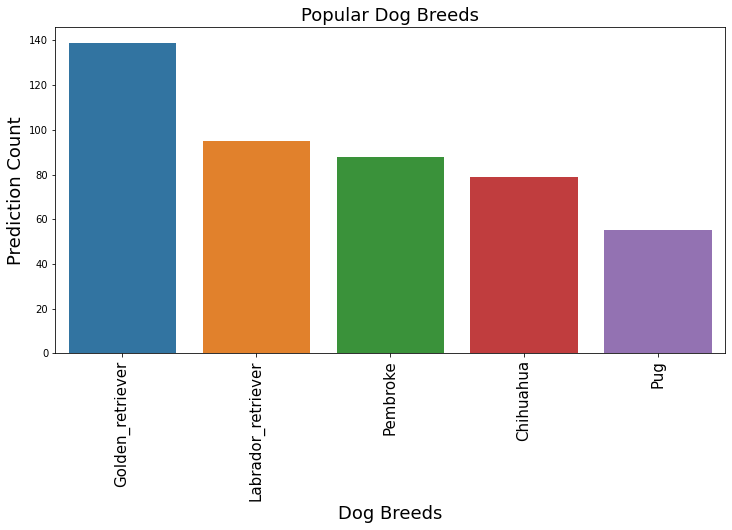

In [100]:
#Plot
plt.figure(figsize = (12,6))
ax = sb.barplot(x = we_rate_dogs_master['first_prediction'].value_counts()[0:5].index,
            y =we_rate_dogs_master['first_prediction'].value_counts()[0:5],
            data = we_rate_dogs_master);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);

#Labeling the plot
plt.xlabel("Dog Breeds",fontsize = 18);
plt.ylabel("Prediction Count",fontsize = 18);
plt.title("Popular Dog Breeds",fontsize = 18);

**Insights:** From the above chart, `Golden_retriever` is the most popular dog breed.

>### Top 3 Rated dogs among the Popular dog breed - Golden Retriever
In this insight, I will further analyze the most popular dog breed (**Golden Retriever**)

In [101]:
#Creating a dataframe to contain all the Golden Retriever dog breed
golden_retriever_df = we_rate_dogs_master.query('first_prediction == "Golden_retriever"')

In [102]:
#Visually displaying the extracted dataframe for further analyzing
golden_retriever_df

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rating,dog_stage,jpg_url,img_num,...,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorite_count,retweet_count
14,889531135344209921,2017-07-24 17:02:04+00:00,This is Stuart. He's sporting his favorite fan...,13,10,Stuart,1.3,puppo,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1.0,...,0.953442,True,Labrador_retriever,0.013834,True,Redbone,0.007958,True,13352.0,1881.0
16,888917238123831296,2017-07-23 00:22:39+00:00,This is Jim. He found a fren. Taught him how t...,12,10,Jim,1.2,NaN,https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg,1.0,...,0.714719,True,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True,25636.0,3760.0
17,888804989199671297,2017-07-22 16:56:37+00:00,This is Zeke. He has a new stick. Very proud o...,13,10,Zeke,1.3,NaN,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1.0,...,0.469760,True,Labrador_retriever,0.184172,True,English_setter,0.073482,True,22466.0,3534.0
39,883482846933004288,2017-07-08 00:28:19+00:00,This is Bella. She hopes her smile made you sm...,5,10,Bella,0.5,NaN,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1.0,...,0.943082,True,Labrador_retriever,0.032409,True,Kuvasz,0.005501,True,40208.0,8269.0
41,883117836046086144,2017-07-07 00:17:54+00:00,Please only send dogs. We don't rate mechanics...,13,10,None,1.3,NaN,https://pbs.twimg.com/media/DEF2-_hXoAAs62q.jpg,2.0,...,0.949562,True,Labrador_retriever,0.045948,True,Kuvasz,0.002471,True,32507.0,5533.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,667182792070062081,2015-11-19 03:29:07+00:00,This is Timison. He just told an awful joke bu...,10,10,Timison,1.0,NaN,https://pbs.twimg.com/media/CUJPNjOWsAAZRqP.jpg,1.0,...,0.949892,True,Irish_setter,0.010564,True,Chesapeake_bay_retriever,0.005821,True,12543.0,5275.0
1946,667160273090932737,2015-11-19 01:59:39+00:00,This is Bradlay. He is a Ronaldinho Matsuyama ...,11,10,Bradlay,1.1,NaN,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,1.0,...,0.471351,True,Miniature_poodle,0.091992,True,Standard_poodle,0.087385,True,219.0,50.0
1954,667044094246576128,2015-11-18 18:17:59+00:00,12/10 gimme now https://t.co/QZAnwgnOMB,12,10,None,1.2,NaN,https://pbs.twimg.com/media/CUHREBXXAAE6A9b.jpg,1.0,...,0.765266,True,Labrador_retriever,0.206694,True,Seat_belt,0.010667,False,163.0,43.0
1985,666345417576210432,2015-11-16 20:01:42+00:00,Look at this jokester thinking seat belt laws ...,10,10,None,1.0,NaN,https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg,1.0,...,0.858744,True,Chesapeake_bay_retriever,0.054787,True,Labrador_retriever,0.014241,True,245.0,124.0


In [103]:
#Sorting the dataframe by rating
golden_retriever_df.sort_values(by = 'rating',ascending = False,inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [104]:
#Displaying the dataframe by top rated
golden_retriever_df

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rating,dog_stage,jpg_url,img_num,...,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog,favorite_count,retweet_count
394,810984652412424192,2016-12-19 23:06:23+00:00,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,3.428571,NaN,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1.0,...,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,5058.0,1330.0
408,807621403335917568,2016-12-10 16:22:02+00:00,This is Ollie Vue. He was a 3 legged pupper on...,14,10,Ollie,1.400000,pupper,https://pbs.twimg.com/media/CzU_YVGUUAA3Xsd.jpg,3.0,...,0.873233,True,Cocker_spaniel,0.033693,True,Chow,0.020408,True,13854.0,3388.0
284,828650029636317184,2017-02-06 17:02:17+00:00,"Occasionally, we're sent fantastic stories. Th...",14,10,One,1.400000,NaN,https://pbs.twimg.com/media/C3_0yhCWEAETXj2.jpg,1.0,...,0.649209,True,Chesapeake_bay_retriever,0.198560,True,Vizsla,0.056200,True,8963.0,1241.0
515,786363235746385920,2016-10-13 00:29:39+00:00,This is Rizzo. He has many talents. A true ren...,13,10,Rizzo,1.300000,doggo,https://pbs.twimg.com/media/Cum5LlfWAAAyPcS.jpg,1.0,...,0.929266,True,Labrador_retriever,0.062867,True,Saluki,0.002157,True,10284.0,3220.0
486,791672322847637504,2016-10-27 16:06:04+00:00,When she says you're a good boy and you know y...,13,10,None,1.300000,NaN,https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg,1.0,...,0.705092,True,Labrador_retriever,0.219721,True,Kuvasz,0.015965,True,11151.0,2927.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,740359016048689152,2016-06-08 01:45:19+00:00,This is Chase. He's in a predicament. 9/10 hel...,9,10,Chase,0.900000,NaN,https://pbs.twimg.com/media/CkZImGVUoAAwv0b.jpg,1.0,...,0.863687,True,Kuvasz,0.048590,True,Labrador_retriever,0.047397,True,3051.0,798.0
812,740373189193256964,2016-06-08 02:41:38+00:00,"After so many requests, this is Bretagne. She ...",9,11,None,0.818182,NaN,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3.0,...,0.807644,True,Kuvasz,0.101286,True,Labrador_retriever,0.023785,True,32603.0,12141.0
1830,669216679721873412,2015-11-24 18:11:04+00:00,This is Clarq. He's a golden Quetzalcoatl. Cla...,8,10,Clarq,0.800000,NaN,https://pbs.twimg.com/media/CUmJBS5WUAAKtrP.jpg,1.0,...,0.992758,True,Irish_setter,0.003379,True,Saluki,0.001230,True,1058.0,348.0
1628,673295268553605120,2015-12-06 00:17:55+00:00,Meet Eve. She's a raging alcoholic 8/10 (would...,8,10,Eve,0.800000,pupper,https://pbs.twimg.com/media/CVgGc9hWIAIe1bn.jpg,1.0,...,0.889241,True,Labrador_retriever,0.064683,True,Great_pyrenees,0.012613,True,6736.0,2752.0


In [105]:
#Finally, displaying the top 3 rated dogs among the popular breed
golden_retriever_df=golden_retriever_df.loc[:,['rating','favorite_count','jpg_url','first_prediction', 'name']][0:3]
golden_retriever_df

,rating,favorite_count,jpg_url,first_prediction,name
394,3.428571,5058.0,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,Golden_retriever,Sam
408,1.400000,13854.0,https://pbs.twimg.com/media/CzU_YVGUUAA3Xsd.jpg,Golden_retriever,Ollie
284,1.400000,8963.0,https://pbs.twimg.com/media/C3_0yhCWEAETXj2.jpg,Golden_retriever,One


Included in the dataframe, is jpg_url. I will use this to display the images of those dogs.

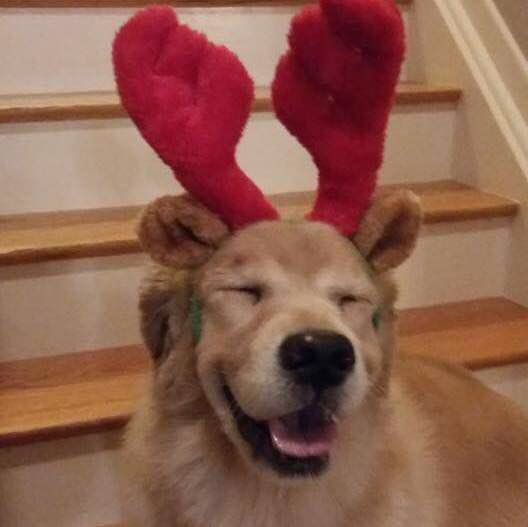

In [106]:
#First dog 
url = golden_retriever_df.jpg_url.iloc[0]
response = requests.get(url)
Image.open(BytesIO(response.content))

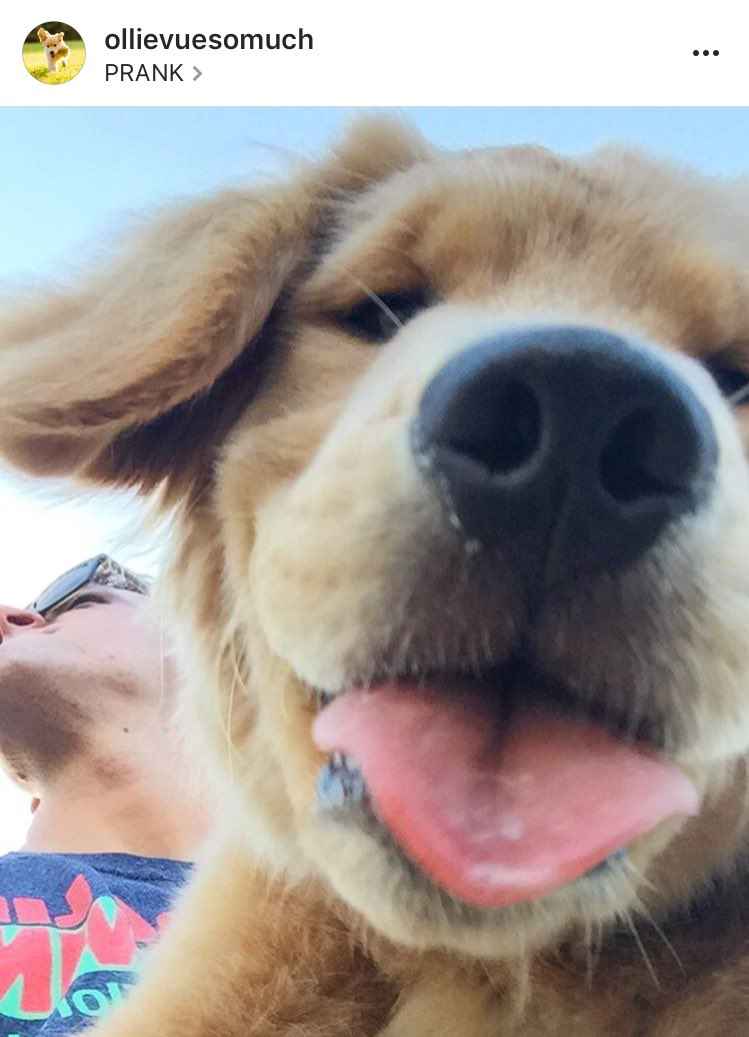

In [108]:
#Second dog
url = golden_retriever_df.jpg_url.iloc[1]
response = requests.get(url)
Image.open(BytesIO(response.content))

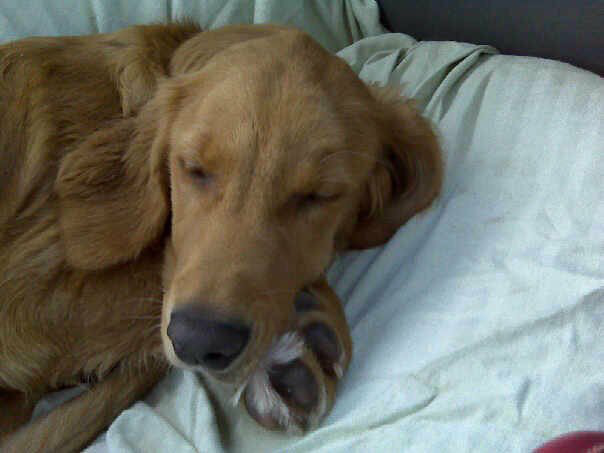

In [109]:
#Third dog
url = golden_retriever_df.jpg_url.iloc[2]
response = requests.get(url)
Image.open(BytesIO(response.content))

>### Retweet Count, Favorite Count and Ratings
In this insight, I will further analyze the Rating, Retweet and Favorite Counts

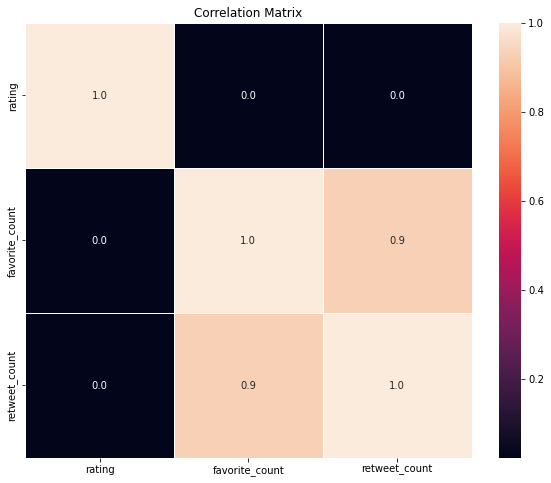

In [110]:
#Plotting correlation plot for Ratings, Retweet and Favorite to check relationships
f,ax = plt.subplots(figsize=(10, 8))
sb.heatmap(we_rate_dogs_master[['rating', 'favorite_count', 'retweet_count']].corr(), annot=True, linewidths=.5, fmt= '.1f')
plt.title('Correlation Matrix');

<Figure size 720x1080 with 0 Axes>

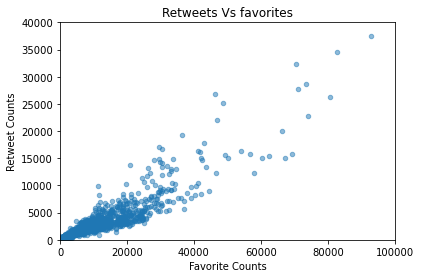

In [111]:
# favorite_count and retweet_count
plt.figure(figsize=(10, 15))
we_rate_dogs_master.plot(kind = 'scatter', x = 'favorite_count', y = 'retweet_count', alpha = 0.5)
plt.xlim((0,100000))
plt.ylim((0,40000))
plt.xlabel('Favorite Counts')
plt.ylabel('Retweet Counts')
plt.title('Retweets Vs favorites');

From above, I can conclusively say that there is strong positive correlation between Favorite Counts and Retweet Counts i.e a linear relationship between the retweet counts and the favorite counts.

### Insights Summary:
1. `Golden_retriever` is the most popular dog breed.

2. Analyzed the most popular dog breed and found out that these are the top 3 rated Golden retriever dogs:
> 1. Sam
> 2. Ollie
> 3. One

3. There is strong positive correlation between Favorite Counts and Retweet Counts i.e a linear relationship between the retweet counts and the favorite counts.

## Navigate to any part of the Notebook
**Just Click a section you want to go**
<ul>
<li><a href="#gather">Data Gathering</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#store">Storing Data</a></li>
<li><a href="#analysis">Analyzing and Visualizing Data</a></li>
    
</ul>